In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y.%m.%d_%H:%M:%S')
df = pd.read_csv("./example3.csv", parse_dates=[0], header=None, date_parser=dateparse, index_col=0)

### Todo:

##### Task 1:

Check how driver drives at every hour of the day. Make comparisons between different days during same hours. This will tell us if the time of the day makes a difference in the 
- avg. driving speed(kph) i.e how time of the day effects the driving speed.
- MapMatching i.e if during specific times logging are not working correctly.
- ProbeSource i.e which data provider provides max information during that time.

###### Unique Days

In [5]:
len(df.index.map(lambda t: t.date()).unique())

1050

In [ ]:
df.groupby([df.index.date]).describe()

In [ ]:
groupedday_hr = df.groupby([df.index.date,df.index.hour])[1].mean()
groupedday_hr

###### divided each day into 4 quaters. 
- q1 = 00:00 to 06:00
- q2 = 06:00 to 12:00
- q3 = 12:00 to 18:00
- q4 = 18:00 to 23:00

###### And than, visualized the distribution of  speed values among different times of the day. The following points can be observed from the results.
- The plot of q1 suggests most of the people are driving slightly above 40km/h. This is the only quarter where most of the drivers prefer to go around 40km/h or more (on average) while for the other quarters(q2,q3,q4) it can be observed that there are two spikes in the graphs. This can be due to the fact that the other quarters represent more busy parts of the day where drivers can be caused to slow down.

- 

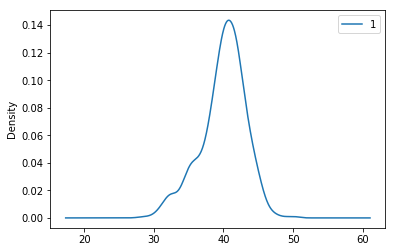

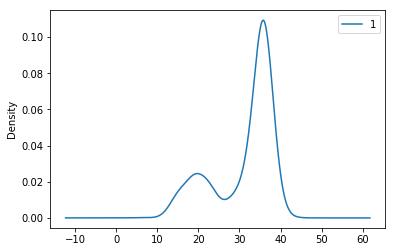

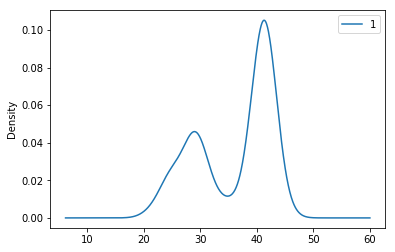

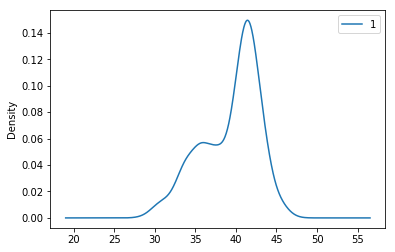

In [10]:
result = groupedday_hr.reset_index(level=0)

result[2] = np.where((result[0] >= 0) & (result[0] < 6),'q1','q2')
result.loc[(result[0]>=12) & (result[0]<18),2] = 'q3'
result.loc[(result[0]>=18) & (result[0]<24),2] = 'q4'

## now we group w.r.t dates and quartes and find out how drivers drove every day on those specific quarters.
quarters_avg_speed = result.groupby([result.index,result[2]])[1].mean().reset_index(level=1)
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q1'].plot.kde()
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q2'].plot.kde()
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q3'].plot.kde()
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q4'].plot.kde()

##### Task 2:
    
Find the reason for not being able to capture the MapMatching values. This could be done using two methods.

- check the car speed whereever we have NAN and where we don't have NAN. Make comparisons.
- check the logging time difference.